# Modelos de Crescimento Econômico: **A Curva de Phillips** 

Qual é a relação entre desemprego e inflação? 

A lógica de Phillips (1958) é que, em momentos de aquecimento no mercado de trabalho (ou seja, baixo desemprego), as pessoas tem mais renda e, consequentemente, consomem mais, o que eleva a inflação.

Além disso, um mercado de trabalho rígido - com poucas pessoas sem emprego -, favorece negociações salariais: as empresas não podem se dar ao luxo de perder funcionários, uma vez que seria díficil encontrar outras pessoas livres no mercado.

----

## Leitura dos Dados

In [1]:
## Atualizando statsmodels
from IPython.display import clear_output # limpa o output de uma célula
!pip uninstall statsmodels -y
!pip install statsmodels

clear_output()  # limpando o texto

In [2]:
## Importando o que for necessário
# Manipulação de dados
import pandas as pd
import numpy as np

# Testes e regressões
from scipy import stats
import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col
import statsmodels.stats.api as sms
from statsmodels.formula.api import ols
from patsy import dmatrices

# Séries Temporais
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA 
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Gráficos
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from matplotlib import style

style.use('ggplot')

In [3]:
### Montando o Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
## Lendo os dados
# Os dados são os mesmos usados por Phillips (1958) e se referem à Inglaterra.
# A única diferença é que, aqui, possuímos dados de 1861 a 1987
sCaminho = "/content/drive/MyDrive/Projetos/IDP/MBA/SetorPublicoIII/Códigos/Aula 4 - 09_12_2021/"
sArquivo = "CurvaPhillips.dta"

## Lendo o DataFrame
data = pd.read_stata(f"{sCaminho}{sArquivo}")

# Vendo o tamanho da base
print(f"Linhas: {data.shape[0]}; Colunas: {data.shape[1]}")

Linhas: 131; Colunas: 9


In [5]:
## Vendo o DataFrame
data.head(10)

# p: log do índice de preços ao consumidor
# w: log do salário nominal
# u: taxa de desemprego

# prefixo d (dp, dw, du): primeira diferença
# u1: primeira defasagem de u
# dp1: primeira defasagem de dp

,p,w,u,dp,dw,du,u1,dp1,year
0,-3.2797,-4.4629,0.0411,-0.0393,-0.0408,0.0100,0.0311,0.0072,1857.0
1,-3.3000,-4.4911,0.0713,-0.0203,-0.0282,0.0302,0.0411,-0.0393,1858.0
2,-3.2816,-4.4911,0.0256,0.0184,0.0000,-0.0457,0.0713,-0.0203,1859.0
3,-3.2606,-4.4629,0.0177,0.0210,0.0282,-0.0079,0.0256,0.0184,1860.0
4,-3.2627,-4.4629,0.0359,-0.0021,0.0000,0.0182,0.0177,0.0210,1861.0
5,-3.2359,-4.4629,0.0584,0.0268,0.0000,0.0225,0.0359,-0.0021,1862.0
6,-3.2053,-4.4355,0.0459,0.0306,0.0274,-0.0125,0.0584,0.0268,1863.0
7,-3.1845,-4.3958,0.0187,0.0208,0.0397,-0.0272,0.0459,0.0306,1864.0
8,-3.1773,-4.3828,0.0178,0.0072,0.0130,-0.0009,0.0187,0.0208,1865.0
9,-3.1516,-4.3451,0.0258,0.0257,0.0377,0.0080,0.0178,0.0072,1866.0


Importante: logs também são úteis para aproximar variações percentuais. Assim, uma variação percentual entre x e y pode ser aproximada (para valores pequenos, como costumam ser o caso de percentuais) por $\log (x) - \log (y)$.

No caso de inflação, por exemplo, ela pode ser tomada como $\pi_t = \frac{P_t}{P_{t-1}} - 1$ ou como $log(P_t) - log(P_{t-1})$, onde $P$ é um índice de preços.

Usaremos muito essa propriedade nesse notebook!

## Análises

In [6]:
## Assim como Phillips (1958), vamos filtrar os dados para 1861 a 1913
nAno1 = 1861
nAno2 = 1913
dataPhillips = data.query(f"(year >= {nAno1}) & (year <= {nAno2})").copy()

In [7]:
## Vamos fazer uma regressão entre a primeira diferença no índice de preços e a variação da taxa de desemprego
# Assim, captamos o efeito da variação do desemprego sobre a variação dos preços (inflação), aproximada pela diferença nos logs

# Fórmula
formula = "dp ~ du"

# Modelo (com covariância robusta)
modelo = ols(formula=formula, data=dataPhillips).fit(cov_type="HC1", use_t=True)

# Sumário
print(modelo.summary())

                            OLS Regression Results                            
Dep. Variable:                     dp   R-squared:                       0.155
Model:                            OLS   Adj. R-squared:                  0.138
Method:                 Least Squares   F-statistic:                     12.54
Date:                Thu, 09 Dec 2021   Prob (F-statistic):           0.000860
Time:                        23:42:46   Log-Likelihood:                 138.48
No. Observations:                  53   AIC:                            -273.0
Df Residuals:                      51   BIC:                            -269.0
Df Model:                           1                                         
Covariance Type:                  HC1                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0017      0.002      0.687      0.4

Text(0, 0.5, '∆ log(preços)')

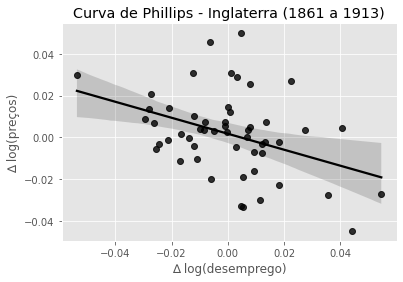

In [8]:
## Como vemos, a relação é negativa: maiores taxas de desemprego estão associadas a menores reajustes de preços (menores inflações)
# Podemos ver isso graficamente usando um regplot
sns.regplot(x="du", y="dp", data=dataPhillips, color="black")

plt.title(f"Curva de Phillips - Inglaterra ({nAno1} a {nAno2})")
plt.xlabel("∆ log(desemprego)")
plt.ylabel("∆ log(preços)")

Text(0, 0.5, 'Inflação')

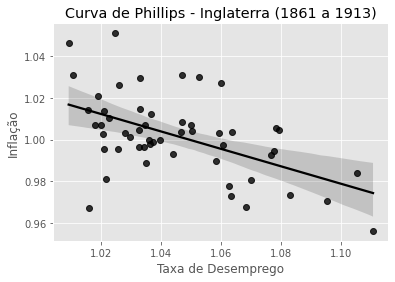

In [10]:
## Contudo, a forma mais tradicional de ver a Curva de Phillips é com a variável desemprego em termos absolutos
# Exponenciando (operação inversa do log)
dataPhillips["taxa_desemprego"] = np.exp(dataPhillips["u"])
dataPhillips["inflacao"] = dataPhillips["dp"]

## Plottando os dados
sns.regplot(x="taxa_desemprego", y="inflacao", data=dataPhillips, color="black")

plt.title(f"Curva de Phillips - Inglaterra ({nAno1} a {nAno2})")
plt.xlabel("Taxa de Desemprego")
plt.ylabel("Inflação")

Fun fact: [a curva de Phillips do Japão parece o Japão!](http://www.econ.yale.edu/smith/econ116a/japan.pdf)

Apesar de ter sido um guia muito importante da política econômica até os anos 1970, a Curva de Phillips foi desafiada por dois economistas famosos: Milton Friedman e Edmund Phelps (1968).

A crítica deles, também feita pelo Nobel Robert Lucas e Thomas Sargent, era que não se podia tomar a curva como um instrumento de política econômica porque as expectativas de inflação dos agentes eram formadas a partir do que eles esperam da política econômica do **futuro**, e não do passado.
Além disso, há todo um economês acerca do desvio da taxa de desemprego natural que não vamos entrar aqui.

Por fim, as crises do petróleo de 1970 (1973 e 1979) criaram uma era em que a Curva de Phillips deixava de fazer sentido: era a famosa **estagflação**, uma combinação de alta inflação e alto desemprego em virtude de desequilíbrios no lado da oferta da economia.

In [11]:
## Criando outro intervalo de anos para o período pós 2ª Guerra
nAnoGuerra1 = 1945
nAnoGuerra2 = 1987

Text(0, 0.5, '∆ log(preços)')

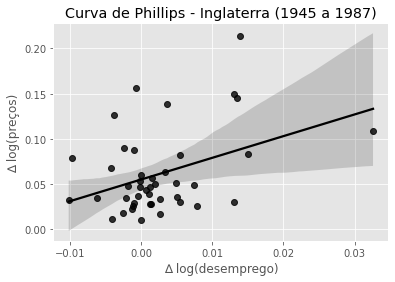

In [12]:
## Por exemplo, vamos fazer a mesma análise gráfica para o período após a 2ª Guerra (1945 a 1987)
sns.regplot(x="du", y="dp", data=data.query(f"(year >= {nAnoGuerra1}) & (year <= {nAnoGuerra2})"), color="black")

plt.title(f"Curva de Phillips - Inglaterra ({nAnoGuerra1} a {nAnoGuerra2})")
plt.xlabel("∆ log(desemprego)")
plt.ylabel("∆ log(preços)")

# Temos agora uma relação positiva!

Text(0, 0.5, '∆ log(preços)')

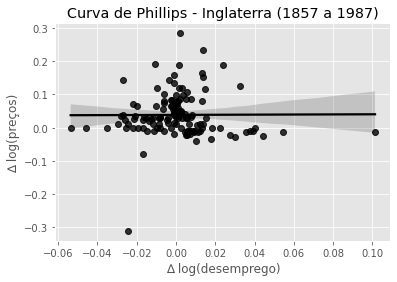

In [13]:
## Considerando todo o período dos nossos dados (1857 a 1987), não parece haver nenhuma relação
sns.regplot(x="du", y="dw", data=data, color="black")

plt.title("Curva de Phillips - Inglaterra (1857 a 1987)")
plt.xlabel("∆ log(desemprego)")
plt.ylabel("∆ log(preços)")

O que os gráficos e as críticas de Friedman, Phelps e Lucas mostram é que relações macroeconômicas observadas em um período não podem ser generalizadas. 

Desta forma, é preciso reforçar a teoria da Curva de Phillips, inserindo as famosas expectativas de inflação e a "taxa de desemprego natural" (desemprego que levaria a uma taxa de inflação constante ao longo do tempo).

Apesar disso resolver alguns problemas, ela cria outros: ambas as novas variáveis (expectativas e desemprego natural) não são observadas diretamente e precisam ser **estimadas**, o que cria um novo grau de incerteza na análise.

Para a questão das expectativas, Friedman e Phelps propuseram *expectativas adaptativas*, ou seja, formadas a partir de ponderações das inflações passadas.

Lucas e Sargent, por sua vez, propõe *expectativas racionais*, nas quais os agentes incorporam (de forma imperfeita) a informação disponível no presente acerca do futuro. Tal análise ficou conhecida como "A Metáfora das Ilhas de Lucas" e é interessante para quem quiser dar uma olhada.

Basicamente, essa teoria diz que o melhor chute para a inflação do futuro é a inflação do presente (ela seria uma série com ruído branco). Dessa forma, como as expectativas seriam aleatórias, a curva de Phillips seria um instrumento espúrio de política econômica (sem nenhuma validade prática) e a taxa de desemprego flutuaria em torno da natural por conta de choques imprevisíveis de oferta e demanda.

Contudo, alguns estudos empíricos encontraram resultados nada favoráveis à teoria de Lucas e Sargent, mesmo na época em que ela foi proposta.

Em virtude disso, vamos estimar o modelo de Friedman e Phelps.

## Curva de Phillips com Expectativas Adaptativas (Friedman e Phelps)

No caso em que os agentes determinam suas expectativas de inflação baseados apenas no período mais recente, a curva de Phillips pode ser escrita como:

\begin{align*}
\pi_t = \pi_{t-1} - \beta (u_t - u^n) + v_t,
\end{align*}

em que $u^n$ é a taxa natural de desemprego e $v_t$ representa eventuais choques de oferta. $\beta$ é um parâmetro que diz a sensibilidade da inflação à variações no desemprego.


$\pi_t$ é a nossa variável `dp` (inflação aproximada pela diferença entre os logs dos níveis de preços) e $\pi_{t-1}$ é `dp1`, sendo $u_t$ igual a `u` e $v_t$ captado pelo termo de erro do modelo.

O desafio aqui seria estimar a taxa natural de desemprego, Contudo, subtraindo $\pi_{t-1}$ dos dois lados e sendo $\pi_{t-1} = \pi_{t-2} - \beta (u_{t-1} - u^n) + v_{t-1}$:

\begin{align*}
\pi_t - \pi_{t-1} = \pi_{t-1} - \beta (u_t - u^n) + v_t - (\pi_{t-2} - \beta (u_{t-1} - u^n) + v_{t-1})
\end{align*}

Note que podemos cancelar $\beta \cdot u^n$! Rearranjando os termos:

\begin{align*}
\Delta\pi_t = \Delta\pi_{t-1} - \beta \Delta u_t + \Delta v_t
\end{align*}

$\Delta\pi_t$ é `dp - dp1` (variação da inflação) e $\Delta\pi_{t-1}$ é `dp1 - dp2` (`dp2` precisa ser criada), sendo $\Delta u_t$ igual a `du` e $\Delta v_t$ captado pelo termo de erro do modelo.

In [14]:
## Vamos focar a análise entre 1950 e 1987, mas, para isso, precisaremos dos dados a partir de 1948 (ficará claro mais a frente o porquê)
nAnoAnalise1 = 1950
nAnoAnalise2 = 1987
nAnoCorteDados = 1948

dataPhillipsExpec = data.query(f"(year >= {nAnoCorteDados}) & (year <= {nAnoAnalise2})").copy()

## Tornando ano como index
dataPhillipsExpec.set_index('year', inplace=True)

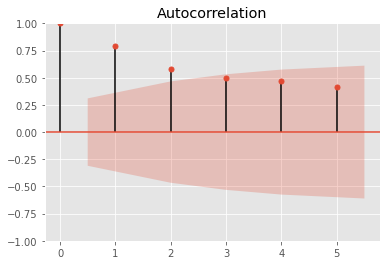

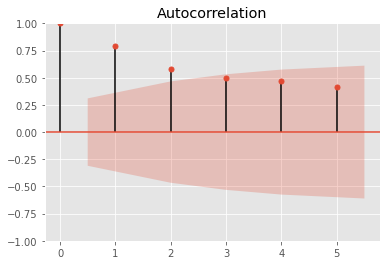

In [15]:
## Primeiramente, vamos ter que analisar se a inflação (variação de índice de preços = dp) corrente realmente é correlacionada com a passada
plot_acf(dataPhillipsExpec['dp'], lags=5)

# Os dados se adaptam bem ao modelo, com a exceção de que a inflação passada é significativamente correlacionada
# com a inflação de até dois anos trás, e não de um como prega o modelo

Contudo, o que importa é a autocorrelação parcial, uma vez que a correlação com a inflação de dois anos trás é afetada pela correlação entre ela e a inflação de um ano atrás.

Lembrando: a correlação parcial é extraída de

Y<sub>t</sub> = A + B<sub>1</sub> Y<sub>t-1</sub> + B<sub>2</sub> Y<sub>t-2</sub>...

Assim como em uma regressão, esses termos possuem interpretação de efeito **parcial**. A correlação parcial pode, portanto, ser interpretada como a correlação entre a série e seus valores anteriores EXCLUINDO-SE a contribuição da correlação de valores passados "intermediários".

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


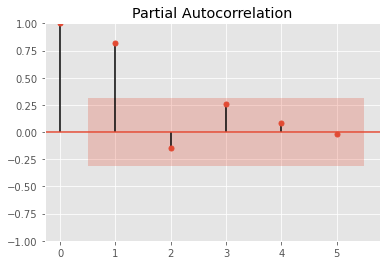

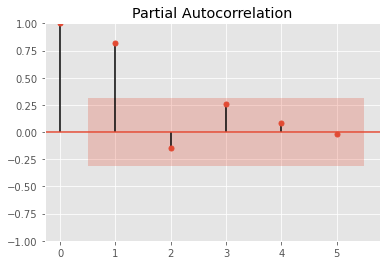

In [17]:
## Autocorrelação parcial
plot_pacf(dataPhillipsExpec['dp'], lags=5)

# Como se pode ver, apenas a inflação imediatamente anterior está correlacionada com a inflação atual, o que corrobora nosso modelo

In [18]:
## Contudo, note que a equação queremos estimar envolve não a inflação (primeira diferença dos logs dos índices de preço),
## mas sim a VARIAÇÃO dela, dada por dp - dp1
dataPhillipsExpec["delta_dp"] = dataPhillipsExpec["dp"] - dataPhillipsExpec["dp1"]

## Além disso, precisamos da variação da inflação no ano anterior
# Criando coluna auxiliar (dp1 puxada uma linha pra baixo)
dataPhillipsExpec["dp2"] = dataPhillipsExpec["dp1"].shift(1)

# Variação da inflação no ano anterior
dataPhillipsExpec["delta_dp1"] = dataPhillipsExpec["dp1"] - dataPhillipsExpec["dp2"]

## Coletando apenas os dados a partir de 1950
dataPhillipsExpec.query(f"index >= {nAnoAnalise1}", inplace=True)

# Vendo resultado
dataPhillipsExpec.head()

,p,w,u,dp,dw,du,u1,dp1,delta_dp,dp2,delta_dp1
year,,,,,,,,,,,
1950.0,-1.9792,-2.7062,0.0130,0.0278,0.0515,0.0014,0.0116,0.0254,0.0024,0.0605,-0.0351
1951.0,-1.8890,-2.6232,0.0106,0.0902,0.0830,-0.0024,0.0130,0.0278,0.0624,0.0254,0.0024
1952.0,-1.8373,-2.5383,0.0155,0.0517,0.0849,0.0049,0.0106,0.0902,-0.0385,0.0278,0.0624
1953.0,-1.8149,-2.4821,0.0142,0.0224,0.0562,-0.0013,0.0155,0.0517,-0.0293,0.0902,-0.0385
1954.0,-1.7964,-2.4165,0.0117,0.0185,0.0656,-0.0025,0.0142,0.0224,-0.0039,0.0517,-0.0293


In [19]:
## Como usaremos delta_dp, delta_dp1 e du, temos que destar suas estacionariedades
## Para isso, usaremos o Teste de Aumentado de Dickey-Fueller

# delta_dp (variação da inflação desse ano)
resultado_adf = adfuller(dataPhillipsExpec['delta_dp'], autolag='AIC')
print(f"P-valor do teste: {resultado_adf[1]}")
print("H0: a série NÃO é estacionária e possui raiz unitária.")

# Tudo ok! Rejeitamos H0 e a série é estacionária

P-valor do teste: 4.5625105597300706e-07
H0: a série NÃO é estacionária e possui raiz unitária.


In [20]:
# delta_dp1 (variação da inflação do ano anterior)
resultado_adf = adfuller(dataPhillipsExpec['delta_dp1'], autolag='AIC')
print(f"P-valor do teste: {resultado_adf[1]}")
print("H0: a série NÃO é estacionária e possui raiz unitária.")

# Tudo ok! Rejeitamos H0 e a série é estacionária

P-valor do teste: 2.47691343297544e-07
H0: a série NÃO é estacionária e possui raiz unitária.


In [21]:
# delta_u (variação da taxa de desemprego)
resultado_adf = adfuller(dataPhillipsExpec['du'], autolag='AIC')
print(f"P-valor do teste: {resultado_adf[1]}")
print("H0: a série NÃO é estacionária e possui raiz unitária.")

# Tudo ok! Rejeitamos H0 e a série é estacionária

P-valor do teste: 0.00014334375629027873
H0: a série NÃO é estacionária e possui raiz unitária.


Note que as estacionariedades são auxiliadas pelo fato de que já diferenciamos nossas variáveis em virtude da própria forma do modelo.

In [22]:
## Vamos, por fim, ao modelo
## Como já temos delta_dp e delta_dp1, vamos usar MQO normal, mas o mesmo poderia ser feito com um AR(1)
## Os resultados seriam um pouco diferentes por conta da forma como AR é estimado (não é por MQO), mas devem ser próximos

# Formula
formula_expectativas = "delta_dp ~ 1 + delta_dp1 + du"

# Modelo
modelo_expectativas = ols(formula=formula_expectativas, data=dataPhillipsExpec).fit(cov_type="HC1", use_t=True)

# Sumário
print(modelo_expectativas.summary())

                            OLS Regression Results                            
Dep. Variable:               delta_dp   R-squared:                       0.123
Model:                            OLS   Adj. R-squared:                  0.073
Method:                 Least Squares   F-statistic:                     6.548
Date:                Fri, 10 Dec 2021   Prob (F-statistic):            0.00384
Time:                        00:13:23   Log-Likelihood:                 82.687
No. Observations:                  38   AIC:                            -159.4
Df Residuals:                      35   BIC:                            -154.5
Df Model:                           2                                         
Covariance Type:                  HC1                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0040      0.005      0.805      0.4

Como esperado, o modelo acima diz que uma variação positiva da taxa de desemprego (ou seja, mais pessoas desempregadas) causa uma queda na variação da inflação - resultado agora consistente com a teoria (lembre que, quando fizemos a análise gráfica da Curva de Phillips Tradicional para o mesmo período, tinhamos encontrado uma relação positiva).

Além disso, vemos que há uma persistência inflacionária (delta_dp1 > 0), mas seu coeficiente não é significativo com a nossa amostra.

Lembrando: precisamos de que o erro seja um ruído branco, ou seja, homoscedástico, normal e sem autocorrelação.

O sumário nos fornece o teste de Jarque-Bera de normalidade, onde H0: normal.

Como não podemos rejeitar H0 (vide `Prob(JB)`), podemos dizer que os dados seguem uma distribuição normal. 

In [23]:
# Testando heteroscedasticidade usando Breusch-Pagan, onde H0: homoscedasticidade
# Para o teste, desconsideramos o componente autorregressivo (delta_dp1),e por isso, passamos apenas os dados
# do intercepto (coluna 0) e du (coluna 2) de .model.exog
teste_heteroscedasticidade = sms.het_breuschpagan(modelo_expectativas.resid, modelo_expectativas.model.exog[:, [0, 2]])

# Pegando o p-valor
print(f"P-valor: {teste_heteroscedasticidade[3]}")
print("H0: homoscedasticidade")

# Não conseguimos rejeitar H0: erro homoscedástico!

P-valor: 0.49756564283429494
H0: homoscedasticidade


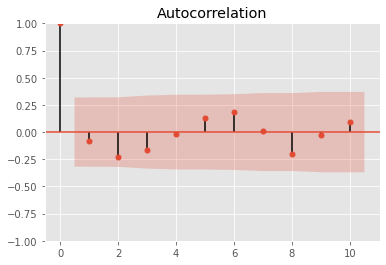

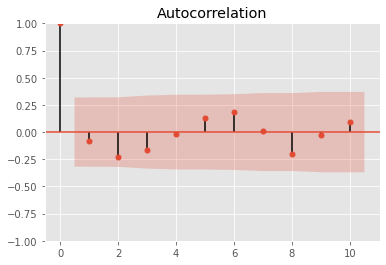

In [24]:
## Por fim, vendo autocorrelação
plot_acf(modelo_expectativas.resid, lags=10)

# Autocorrelação não é significante: temos um ruído branco e nosso modelo está ok!

Note que há Curvas de Phillips com estimadores muito mais completos e empiricamente válidos, mas o propósito aqui não é passar o "estado da arte" desses estimadores, mas sim um *overview* acerca da teoria e estratégias empíricas que podem ser extrapoladas para outros contextos =)

In [25]:
## Fazendo a mesma coisa com um modelo AR(1)
# Lembrando: AR(1) = ARIMA(1, 0, 0)
# p = 1, d = 0, q = 0.
modelo_arima = ARIMA(endog=dataPhillipsExpec["delta_dp"],
                     exog=dataPhillipsExpec["du"],
                     order=(1, 0, 0)).fit()
## Vendo resultados
clear_output()
print(modelo_arima.summary())

                               SARIMAX Results                                
Dep. Variable:               delta_dp   No. Observations:                   38
Model:                 ARIMA(1, 0, 0)   Log Likelihood                  82.218
Date:                Fri, 10 Dec 2021   AIC                           -156.435
Time:                        00:21:58   BIC                           -149.885
Sample:                             0   HQIC                          -154.104
                                 - 38                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0033      0.006      0.578      0.564      -0.008       0.015
du            -1.2334      1.336     -0.923      0.356      -3.853       1.386
ar.L1          0.0287      0.248      0.116      0.9

Os coeficientes são parecidos, mas nossos resultados são estatisticamente insignificantes.

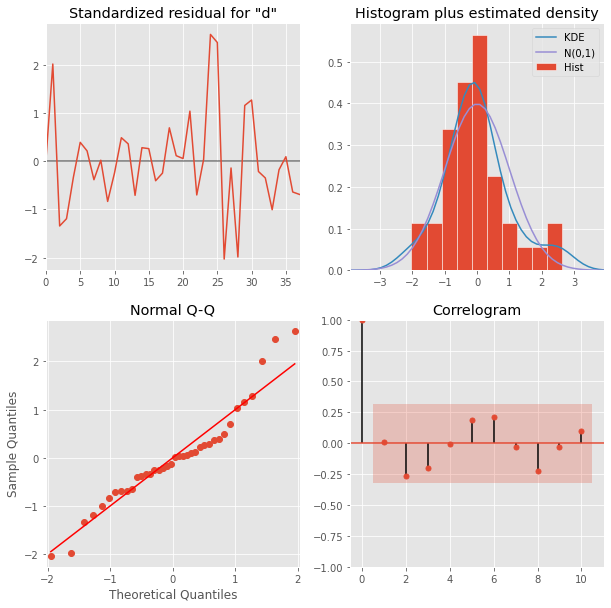

In [26]:
# Vendo diagnósticos
modelo_arima.plot_diagnostics(figsize=(10, 10))
plt.show()

# Pelo sumário (prob(H)), não há heteroscedasticidade (não conseguimos rejeitar a hipótese nula de homoscedasticidade)

# De forma semelhante, Jarque-Bera - que testa normalidade - parece indicar que os dados são normais (p-valor > 0,05),
# mas o gráfico sugere que isso parece ocorrer em virtude do tamanho pequeno da amostra (38 anos).

# O resíduo do modelo não tem autocorrelação. Isso + heteroscedasticidade = ruído branco!

# Obrigado!